In [6]:
import polars as pl 
import polars_ds as pds
import polars_xdt as xdt
import polars.selectors as cs
import holidays
import os 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.category")



## Read the data 

In [7]:
data = pl.read_csv('train.csv')

Clean the column names 

In [8]:
data = (data
.select(pl.all().name.map(lambda x:x.lower()))
.select(pl.all().name.map(lambda x:x.replace("-"," ")))
.select(pl.all().name.map(lambda x:x.replace(" ","_")))
)

data.head()

passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
str,str,bool,str,str,f64,bool,f64,f64,f64,f64,f64,str,bool
"""0001_01""","""Europa""",false,"""B/0/P""","""TRAPPIST-1e""",39.0,false,0.0,0.0,0.0,0.0,0.0,"""Maham Ofracculy""",false
"""0002_01""","""Earth""",false,"""F/0/S""","""TRAPPIST-1e""",24.0,false,109.0,9.0,25.0,549.0,44.0,"""Juanna Vines""",true
"""0003_01""","""Europa""",false,"""A/0/S""","""TRAPPIST-1e""",58.0,true,43.0,3576.0,0.0,6715.0,49.0,"""Altark Susent""",false
"""0003_02""","""Europa""",false,"""A/0/S""","""TRAPPIST-1e""",33.0,false,0.0,1283.0,371.0,3329.0,193.0,"""Solam Susent""",false
"""0004_01""","""Earth""",false,"""F/1/S""","""TRAPPIST-1e""",16.0,false,303.0,70.0,151.0,565.0,2.0,"""Willy Santantines""",true


## Null values

Replacing empty values with null values. All null values will we replaced in sklearn pipeline.

In [9]:
# It is not possible to check if numeric columns contains empty data ("" or " ")
(data
 .select(pl.all().exclude(pl.String),
         pl.when(
    (cs.string()==" ")|(cs.string()==""))
            .then(pl.lit(None))
            .otherwise(cs.string())
            .name.keep())
.null_count()
)



cryosleep,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported,passengerid,homeplanet,cabin,destination,name
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
217,179,203,181,183,208,183,188,0,0,201,199,182,200


In [10]:
# Checking unique passengers
data.select('passengerid').unique().shape[0]==data.shape[0]

True

## Descriptive statistics

### Homeplanet

The majority of the passengers comes from Earth (52 %).

<Axes: xlabel='homeplanet', ylabel='proportion'>

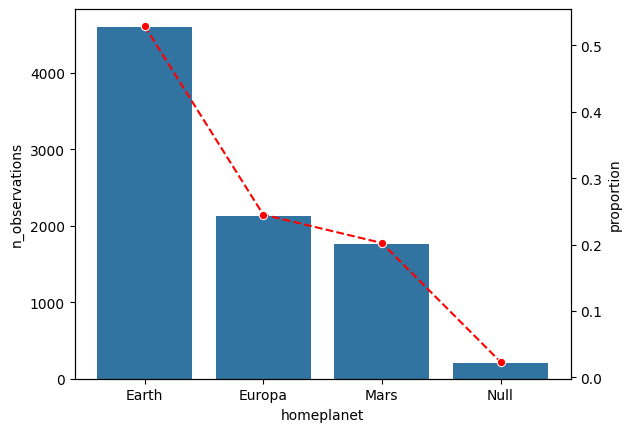

In [11]:
homeplanet = (data
.group_by('homeplanet')
.agg(pl.len().alias('n_observations'))
.with_columns((pl.col('n_observations')/pl.col('n_observations').sum()).alias('proportion'),
              pl.col('homeplanet').fill_null(pl.lit('Null')))
.sort(by ='n_observations',descending = True)
)

# Initialize plot
fig, ax = plt.subplots()

# Initialize the secondary axis
ax_twin = ax.twinx()

# Plot the first axis
sns.barplot(data=homeplanet.to_pandas(),x = 'homeplanet',y = 'n_observations',ax = ax)

# Plot the second axis
sns.lineplot(data=homeplanet.to_pandas(),
             x = 'homeplanet',
             y = 'proportion',
             ax = ax_twin,
             linestyle = '--',
             color = 'r',
             marker="o")

Lets look at the number of passengers who got transported, grouped by homeplanet

<Axes: xlabel='homeplanet', ylabel='n_observations'>

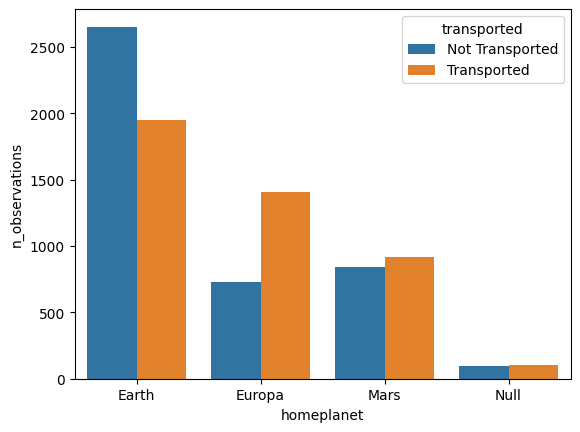

In [24]:
homeplanet_transported = (data
.group_by('homeplanet','transported')
.agg(pl.len().alias('n_observations'))
.sort(by =['homeplanet','n_observations'],descending = [False, True])
)

homeplanet_transported = (homeplanet_transported
.with_columns(pl.col('transported').cast(pl.Int64).replace(1,'Transported').replace(0,'Not Transported'),
              pl.when(pl.col('homeplanet').is_null()).then(pl.lit('Null')).otherwise(pl.col('homeplanet')).keep_name())
.with_columns(proportion = pl.col('n_observations')/pl.col('n_observations').over('transported').sum())
.sort(by = ['homeplanet','transported'])

)

sns.barplot(data = homeplanet_transported.to_pandas(),x = 'homeplanet',y = 'n_observations',hue = 'transported')


60% of the passengers did not have cryosleep.

<Axes: xlabel='cryosleep', ylabel='proportion'>

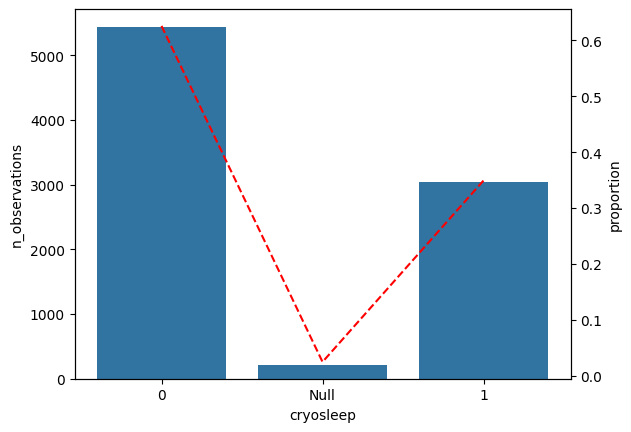

In [37]:
cryosleep = (data
.group_by(pl.col('cryosleep').cast(pl.Int64))
.agg(pl.len().alias('n_observations'))
.with_columns(pl.when(pl.col('cryosleep').is_null()).then(pl.lit('Null')).otherwise(pl.col('cryosleep')).keep_name(),
              (pl.col('n_observations')/pl.col('n_observations').sum()).alias('proportion')
              )
)


# Initialize plot
fig, ax = plt.subplots()

# Initialize the secondary axis
ax_twin = ax.twinx()

sns.barplot(data = cryosleep.to_pandas(),x = 'cryosleep',y = 'n_observations',ax = ax)
sns.lineplot(data = cryosleep.to_pandas(),x = 'cryosleep',y = 'proportion',
             ax = ax_twin,
             linestyle = '--',
             color = 'r',
             markers="o")

Below one can see that cryosleep could be an influential variable. Among those with no cryosleep, the majority did not get transported. 

<Axes: xlabel='cryosleep', ylabel='n_observations'>

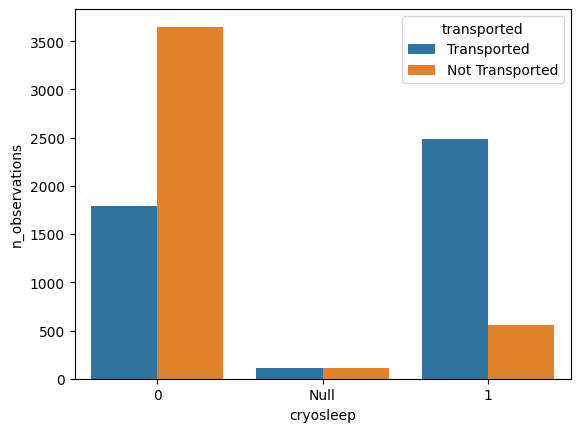

In [42]:
cryosleep_transported = (data
.group_by(pl.col('cryosleep').cast(pl.Int64),'transported')
.agg(pl.len().alias('n_observations'))
.with_columns(pl.when(pl.col('cryosleep').is_null()).then(pl.lit('Null')).otherwise(pl.col('cryosleep')).keep_name(),
              pl.col('transported').cast(pl.Int64).replace(1,'Transported').replace(0,'Not Transported')
              )
)

sns.barplot(data = cryosleep_transported.to_pandas(),x = 'cryosleep',y = 'n_observations',hue = 'transported')


Few VIP 

<Axes: xlabel='vip', ylabel='n_observations'>

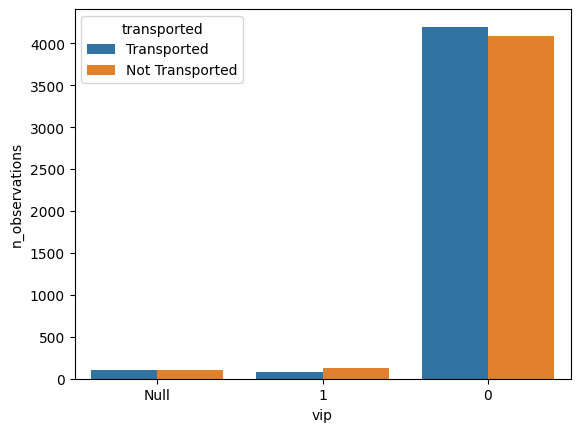

In [43]:
vip = (data
.group_by(pl.col('vip').cast(pl.Int64),'transported')
.agg(pl.len().alias('n_observations'))
.with_columns(pl.when(pl.col('vip').is_null()).then(pl.lit('Null')).otherwise(pl.col('vip')).keep_name(),
              pl.col('transported').cast(pl.Int64).replace(1,'Transported').replace(0,'Not Transported')
              )
)

sns.barplot(data = vip.to_pandas(),x = 'vip',y = 'n_observations',hue = 'transported')
